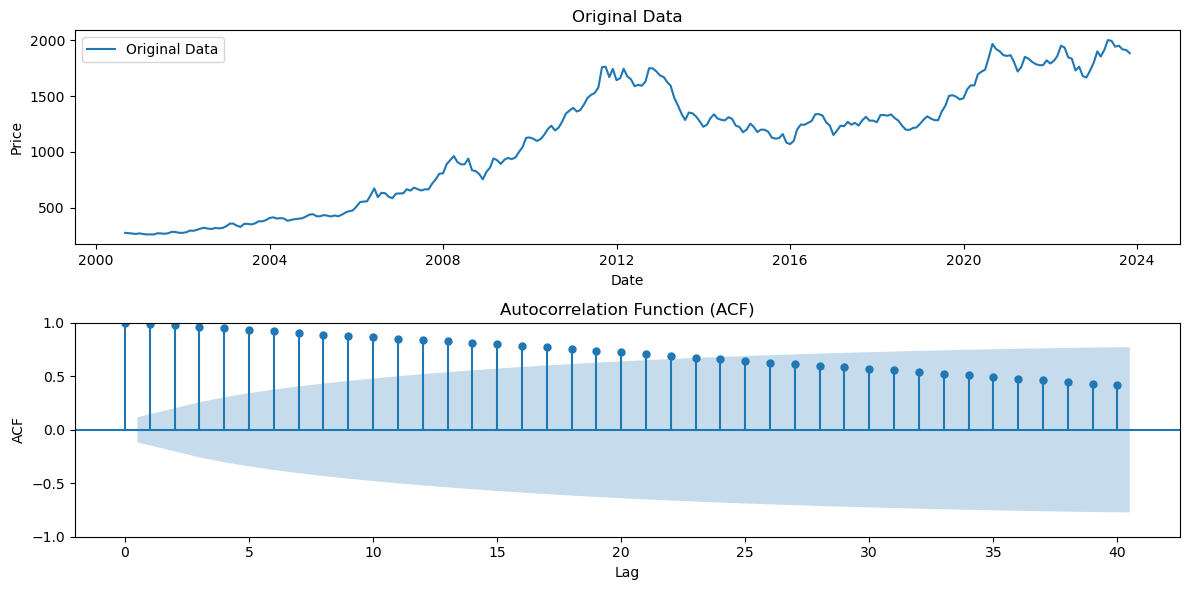

ADF Test Results (Before Differencing):
Test Statistic                  -0.892777
p-value                          0.790342
#Lags Used                       1.000000
Number of Observations Used    277.000000
dtype: float64


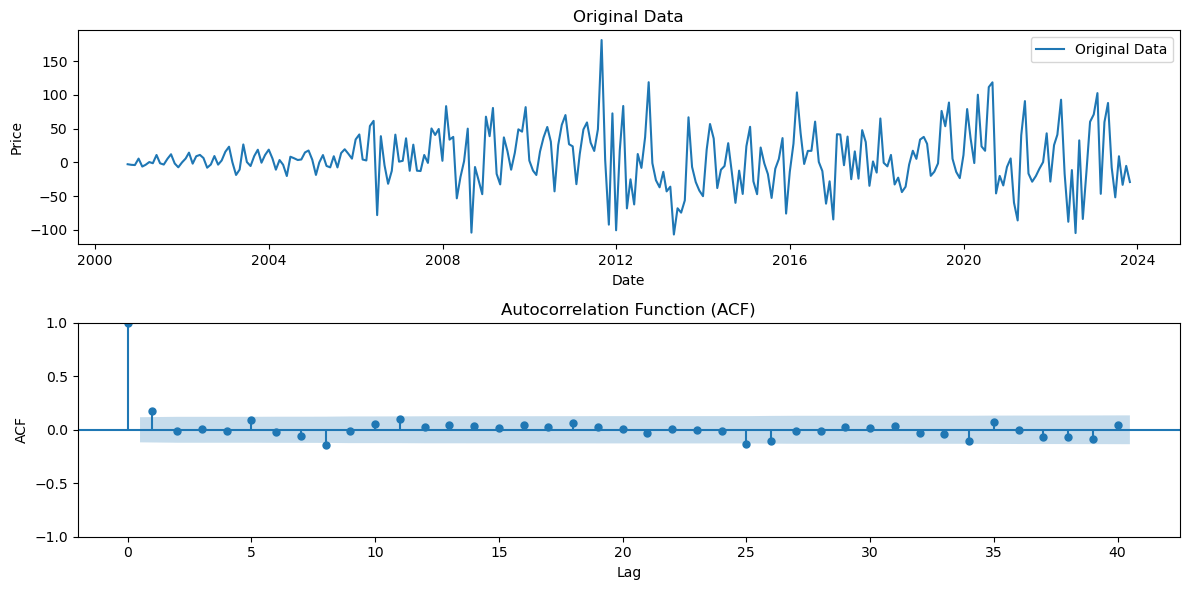

ADF Test Results (After Differencing):
Test Statistic                -1.381163e+01
p-value                        8.210745e-26
#Lags Used                     0.000000e+00
Number of Observations Used    2.770000e+02
dtype: float64


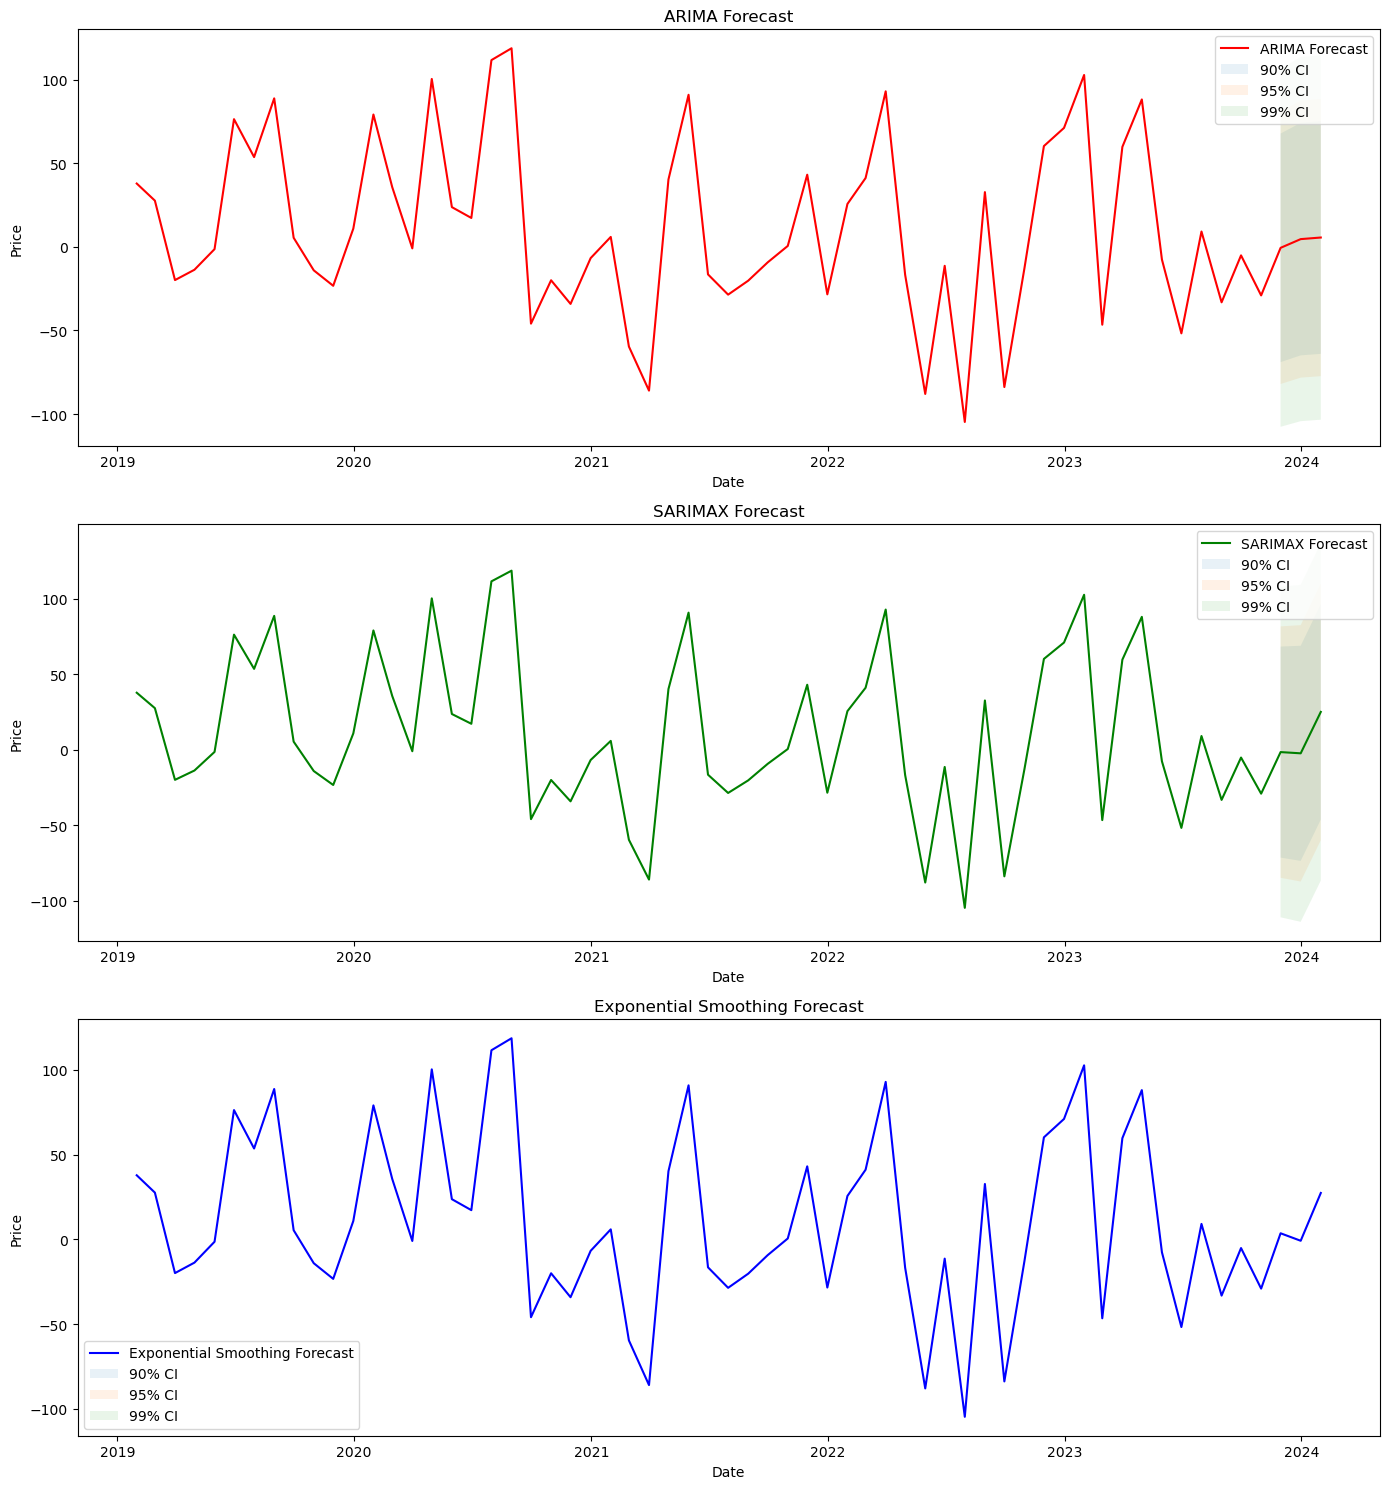

In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from scipy.stats import norm
import numpy as np
import seaborn as sns

# Load and preprocess the data
def load_and_preprocess(file_path):
    # Load the dataset
    data = pd.read_csv(file_path)

    # Convert 'date' column to datetime and sort the data
    data['date'] = pd.to_datetime(data['date'])
    data.sort_values('date', inplace=True)

    # Isolate gold-specific entries and resample to monthly frequency
    gold_data = data[data['commodity'] == 'Gold'][['date', 'close']]
    gold_data.set_index('date', inplace=True)
    return gold_data.resample('M').mean()

# Check stationarity
def check_stationarity(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')
    return pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])

# Plot ACF and PACF
def plot_acf_pacf(timeseries, lags=40):
    plt.figure(figsize=(12, 6))
    plt.subplot(211)
    plt.plot(timeseries, label='Original Data')
    plt.title('Original Data')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()

    plt.subplot(212)
    plot_acf(timeseries, lags=lags, ax=plt.gca())
    plt.title('Autocorrelation Function (ACF)')
    plt.xlabel('Lag')
    plt.ylabel('ACF')

    plt.tight_layout()
    plt.show()

# Plot ADF Test Results
def plot_adf_results(adf_results):
    plt.figure(figsize=(8, 4))
    plt.plot(adf_results.index, adf_results['Test Statistic'], marker='o')
    plt.axhline(y=adf_results['Test Statistic'][0], color='r', linestyle='--')
    plt.title('ADF Test Statistic')
    plt.xlabel('Test')
    plt.ylabel('ADF Test Statistic')
    plt.xticks(rotation=45)
    plt.grid()
    plt.show()

# Model Fitting
def fit_models(data):
    # ARIMA model
    arima_model = ARIMA(data, order=(1, 1, 1))
    arima_result = arima_model.fit()

    # SARIMA model
    sarima_order = (1, 1, 1)
    seasonal_order = (1, 1, 1, 12)
    sarima_model = SARIMAX(data, order=sarima_order, seasonal_order=seasonal_order)
    sarima_result = sarima_model.fit()

    # Exponential Smoothing
    exp_model = ExponentialSmoothing(data, trend='add', seasonal='add', seasonal_periods=12)
    exp_result = exp_model.fit()

    return arima_result, sarima_result, exp_result

# Forecasting and Visualization
def forecast_and_visualize(models, data, standard_error_placeholder):
    arima_result, sarima_result, exp_result = models

    # Define the start date for the plot
    start_date = '2019-01-01'

    # Filter data to start from 2019
    filtered_data = data[data.index >= start_date]

    # Confidence levels for the intervals
    confidence_levels = [0.90, 0.95, 0.99]

    # Creating separate plots for each model
    fig, axes = plt.subplots(3, 1, figsize=(14, 15))

    # Function to plot confidence intervals
    def plot_confidence_intervals(ax, forecast, intervals):
        for level in confidence_levels:
            conf_int = forecast.conf_int(alpha=1-level)
            ax.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], alpha=0.1, label=f'{int(level*100)}% CI')

    # ARIMA and SARIMA Plots
    for model_result, ax in zip([arima_result, sarima_result], axes[:2]):
        forecast = model_result.get_forecast(steps=3)
        combined = pd.concat([filtered_data, forecast.predicted_mean])
        ax.plot(combined, label=f'{model_result.model.__class__.__name__} Forecast', color='red' if model_result == arima_result else 'green')
        plot_confidence_intervals(ax, forecast, confidence_levels)
        ax.set_title(f'{model_result.model.__class__.__name__} Forecast')
        ax.set_xlabel('Date')
        ax.set_ylabel('Price')
        ax.legend()

    # Define standard_error for Exponential Smoothing
    standard_error = standard_error_placeholder

    # Function to manually calculate confidence intervals
    def manual_confidence_intervals(forecast, standard_error, confidence_levels):
        intervals = {}
        for level in confidence_levels:
            z_score = norm.ppf(1 - (1 - level) / 2)
            lower_bound = forecast - z_score * standard_error
            upper_bound = forecast + z_score * standard_error
            intervals[level] = (lower_bound, upper_bound)
        return intervals

    # Exponential Smoothing Plot
    exp_forecast_values = exp_result.forecast(steps=3)
    combined_exp = pd.concat([filtered_data, exp_forecast_values])
    axes[2].plot(combined_exp, label='Exponential Smoothing Forecast', color='blue')

    # Calculate and plot manual confidence intervals for Exponential Smoothing
    exp_conf_intervals = manual_confidence_intervals(exp_forecast_values, standard_error, confidence_levels)
    for level, (lower, upper) in exp_conf_intervals.items():
        axes[2].fill_between(exp_forecast_values.index, lower, upper, alpha=0.1, label=f'{int(level*100)}% CI')

    axes[2].set_title('Exponential Smoothing Forecast')
    axes[2].set_xlabel('Date')
    axes[2].set_ylabel('Price')
    axes[2].legend()

    plt.tight_layout()
    plt.show()

# Main script
if __name__ == "__main__":
    file_path = 'Dataset/all_commodities_data.csv'  # Update with the correct path
    monthly_gold_data = load_and_preprocess(file_path)

    # Plot ADF and ACF before differencing
    plot_acf_pacf(monthly_gold_data['close'], lags=40)
    
    # Check if data is stationary
    adf_test_result = check_stationarity(monthly_gold_data['close'])
    print("ADF Test Results (Before Differencing):")
    print(adf_test_result)

    # Differencing to make the data stationary (you can adjust the order)
    differenced_data = monthly_gold_data['close'].diff().dropna()

    # Plot ADF and ACF after differencing
    plot_acf_pacf(differenced_data, lags=40)

    # Check if differenced data is stationary
    adf_test_result_after_differencing = check_stationarity(differenced_data)
    print("ADF Test Results (After Differencing):")
    print(adf_test_result_after_differencing)

    # Fit models on differenced data
    models = fit_models(differenced_data)

    # Forecasting and Visualization on differenced data
    standard_error_placeholder = 0.1  # Replace with your actual standard error calculation
    forecast_and_visualize(models, differenced_data, standard_error_placeholder)
